# 3D Tuned Alexnet Training Script

Here the original 3D AlexNet model is tuned in order to improve model performance.

This data has been preprocessed using the normalization range of -1100, 600.

In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import load_model
from tensorflow.python.keras.layers import Flatten, Conv3D, MaxPooling3D, Dropout, Input, Dense, Activation
from tensorflow.python.keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
training_images_final = np.load("3d_training_data.npy")
training_labels = np.load("3d_training_labels.npy")
testing_images_final = np.load("3d_testing_data.npy")
testing_labels = np.load("3d_testing_labels.npy")

The callbacks are defined below.

Early stopping monitors validation loss and automatically quits the training process if the validation loss has remained constant/has increased for 3 consecutive epochs. 

Model checkpoint saves the model that performs the best on the validation dataset.

Lr_reduction reduces the learning rate by a factor of 0.1 every time the validation loss has remained constant/has increased for 2 consecutive epochs.

In [3]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model_checkpoint = ModelCheckpoint(filepath='3d_alexnet.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1, min_lr=0.000001)

The model is implemented and trained below. Training logs were preserved.

The following changes were made in an attempt to tune the model:

Batch size = 16 (vs 128)

Learning rate = 0.0001 (vs 0.01)

Optimizer = Adam (vs SGD + momentum)

Regularization (l2) removed

Dropout after FC1 and FC2 changed to 0.6

After various experimentations, it was found that the combination of parameters specified above works best for this dataset and this model.

In [4]:
batch_size = 16
no_epochs = 50
learning_rate = 0.0001
no_classes = 2
validation_split = 0.1
verbosity = 1
X_train = training_images_final
callbacks = [early_stopping, model_checkpoint]

model = Sequential()

model.add(Conv3D(filters=96, input_shape=(111, 111, 20, 3), kernel_size=(11,11,11), strides=(4,4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5,5,5), strides=(1,1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Conv3D(filters=384, kernel_size=(3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('relu'))

model.add(Conv3D(filters=384, kernel_size=(3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Conv3D(filters=256, kernel_size=(3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Flatten())

model.add(Dense(4096, input_shape=(111*111*20*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(no_classes, activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['acc'])

history = model.fit(X_train, training_labels,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split,
            callbacks = callbacks
            )


Train on 1447 samples, validate on 161 samples
Epoch 1/50
1446/1447 [============================>.] - ETA: 0s - loss: 0.6942 - acc: 0.4924
Epoch 00001: val_loss improved from inf to 0.69333, saving model to 3d_alexnet.h5
1447/1447 [==============================] - 282s 195ms/sample - loss: 0.6942 - acc: 0.4921 - val_loss: 0.6933 - val_acc: 0.4969
Epoch 2/50
1446/1447 [============================>.] - ETA: 0s - loss: 0.6936 - acc: 0.5242
Epoch 00002: val_loss improved from 0.69333 to 0.69268, saving model to 3d_alexnet.h5
1447/1447 [==============================] - 278s 192ms/sample - loss: 0.6936 - acc: 0.5245 - val_loss: 0.6927 - val_acc: 0.5528
Epoch 3/50
1446/1447 [============================>.] - ETA: 0s - loss: 0.6926 - acc: 0.5394
Epoch 00003: val_loss did not improve from 0.69268
1447/1447 [==============================] - 276s 191ms/sample - loss: 0.6926 - acc: 0.5390 - val_loss: 0.6937 - val_acc: 0.4969
Epoch 4/50
1446/1447 [============================>.] - ETA: 0s - lo

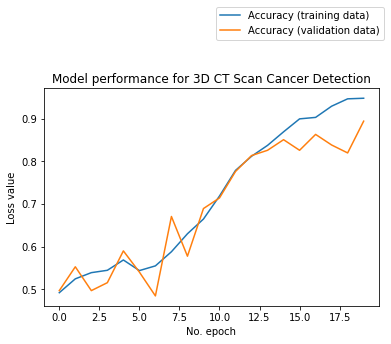

In [6]:
plt.plot(history.history['acc'], label='Accuracy (training data)')
plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance for 3D CT Scan Cancer Detection')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="lower left", bbox_to_anchor=(0.5,1.2))
plt.show()

The model has now been trained. It is then tested on unseen data in order to obtain the final testing accuracy.

In [7]:
test_results = model.evaluate(testing_images_final, testing_labels, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

403/403 [==============================] - 3s 7ms/sample - loss: 0.5449 - acc: 0.8586
Test results - Loss: 0.5448719084114946 - Accuracy: 85.85608005523682%


Finally, further performance metrics are evaluated using the functions below. These metrics are:

Sensitivity: The ability of the model to classify a nodule as malignant when it is actually malignant (TP / (TP+FN))

Specificity: The ability of the model to classify a nodule as benign when it is actually benign (TN/ (TN+FP))

Precision: The accuracy of the model with regards to identifying malignant cases (i.e., how many of the predicted malignant nodules are actually malignant?) 
(TP / (TP+FP))

In [8]:
# parameters:
# arg1: labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: positive: True for positive labels (i.e. malignant), False for negative labels (i.e. benign)

# returns: 
# the number of malignant or benign cases in a one-hot encoded testing labels array

def get_true_labels(labels,positive=True):
    count = 0
    if positive == True:
        for x in labels:
            if x[1] == 1:
                count += 1
    else:
        for x in labels:
            if x[1] == 0:
                count += 1
    return count

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the sensitivity of the model, defined as (TP / (TP+FN))

def get_sensitivity(actual_labels, predicted_labels):
    total_positives = get_true_labels(actual_labels)
    true_positives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [0,1] and predicted_labels[i] == 1:
            true_positives += 1
    return true_positives/total_positives

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the specificity of the model, defined as (TN/ (TN+FP))

def get_specificity(actual_labels, predicted_labels):
    total_negatives = get_true_labels(actual_labels, False)
    true_negatives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [1,0] and predicted_labels[i] == 0:
            true_negatives += 1
    return true_negatives/total_negatives

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the precision of the model, defined as (TP / (TP+FP))

def get_precision(actual_labels, predicted_labels):
    true_positives = 0
    false_positives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [0,1] and predicted_labels[i] == 1:
            true_positives += 1
        if list(actual_labels[i]) == [1,0] and predicted_labels[i] == 1:
            false_positives += 1
    return true_positives/(true_positives+false_positives)

The list of model predictions is obtained and, along with the actual labels, is used to derive the performance metrics of the model.

In [9]:
predicted_labels = model.predict_classes(testing_images_final)

In [10]:
sensitivity = get_sensitivity(testing_labels, predicted_labels)
specificity = get_specificity(testing_labels, predicted_labels)
precision = get_precision(testing_labels, predicted_labels)
print(sensitivity, specificity, precision)

0.7766497461928934 0.9368932038834952 0.9216867469879518


Finally, the performance metrics are saved.

In [11]:
f= open("3d_AlexNet_Results_Opt.txt","w+")
f.write("3D AlexNet Performance Metrics\n")
f.write("Loss: {0}\n".format(test_results[0]))
f.write("Accuracy: {0}\n".format(test_results[1]*100))
f.write("Sensitivity: {0}\n".format(sensitivity))
f.write("Specificity: {0}\n".format(specificity))
f.write("Precision: {0}\n".format(precision))
f.close()

In [14]:
model.save("3d_alexnet_adam.h5")